In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az
from scipy.interpolate import griddata
import pymc3 as pm
from patsy import bs


In [2]:
%config InlineBackend.figure_format='retina'

# Geocentric Models

## Practices

### 4E1.
In the model definition below, which line is the likelihood?

$$
y_{i} ∼ Normal(\mu, \sigma) \\
\mu ∼ Normal(0, 10) \\
\sigma ∼ Exponential(1) \\
$$

**Answer:** The first line is the likelihood

### 4E2.
In the model definition just above, how many parameters are in the posterior distribution?

**Answer:**
There are 2 parameters in the posterior distribution. $\mu$ and $\sigma$

### 4E4. 

In the model definition below, which line is the linear model?

$$
y_{i} ∼ Normal(\mu, \sigma)\\
\mu_{i} = \alpha + \beta x_{i} \\
\alpha ∼ Normal(0, 10) \\
\beta ∼ Normal(0, 1) \\
\sigma ∼ Exponential(2) \\
$$

**Answer:** The second line

### 4E5.
In the model definition just above, how many parameters are in the posterior distribution?
**Answer:** 2+i

### 4M1.

For the model definition below, simulate observed y values from the prior (not the posterior).

$$
y_{i} ∼ Normal(µ, σ) \\
µ ∼ Normal(0, 10) \\
σ ∼ Exponential(1)
$$ 

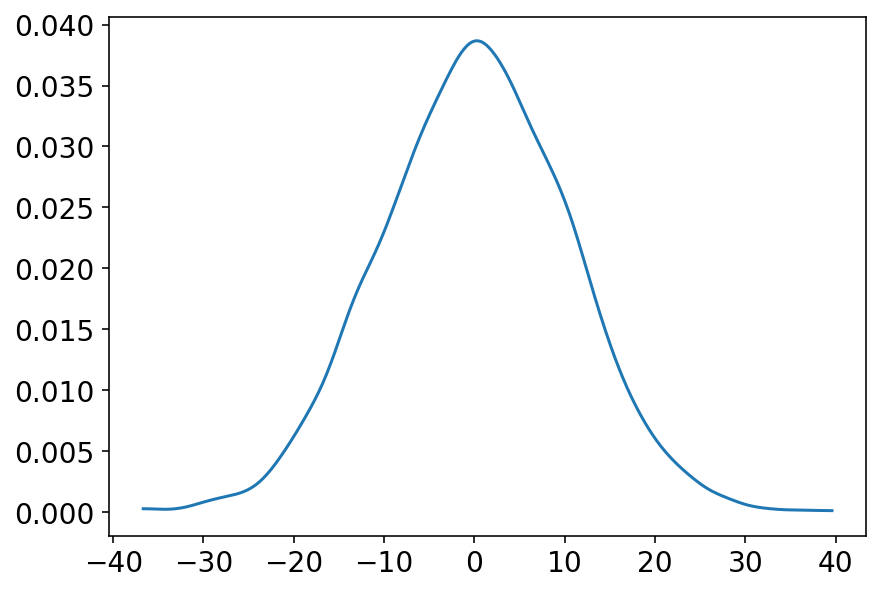

In [3]:
N = 10_000

μ = stats.norm(0, 10).rvs(N)
σ = stats.expon(1).rvs(N)
yi = stats.norm(μ, σ).rvs()

az.plot_kde(yi)
plt.show()

### 4M2.

Translate the model just above into a quap formula.

In [4]:
with pm.Model() as model:
    μ = pm.Normal('μ', 0, 10)
    σ = pm.Exponential('σ', 1)
    yi = pm.Normal('yi', μ, σ)

### 4M3.

Translate the quap model formula below into a mathematical model definition.

```R
y ~ dnorm( mu , sigma ),
mu <- a + b*x,
a ~ dnorm( 0 , 10 ),
b ~ dunif( 0 , 1 ),
sigma ~ dexp( 1 )
```

**Answer:**

$$
y_{i} \sim Normal(\mu, \sigma) \\
\mu = \alpha + \beta \times x \\
\alpha \sim Normal(0, 10) \\
\beta \sim Uniform(0, 1) \\
\sigma \sim Exponential(1)
$$ 

### 4M4. 

A sample of students is measured for height each year for 3 years. After the third year, you want to fit a linear regression predicting height using year as a predictor. Write down the mathematical model definition for this regression, using any variable names and priors you choose. Be prepared to defend your choice of priors

**Answer:**

$$
y_{i} \sim Normal(\mu, \sigma) \\
\mu = \alpha + \beta \times x \\
\alpha \sim Normal(100, 20) \\
\beta \sim LogNormal(0, 1) \\
\sigma \sim Exponential(1)
$$

### 4M5.
Now suppose I remind you that every student got taller each year. Does this information lead you to change your choice of priors? How?

**Answer:** No, I already considered this fact when choosing the prior. That is why I used a LogNormal prior for the $\beta$ parameter

### 4M6.
Now suppose I tell you that the variance among heights for students of the same age is never more than 64cm. How does this lead you to revise your priors?

**Answer:** I might increase the range of the $\sigma$ parameter to accomodate this information

### 4M7. 

Refit model `m4.3` from the chapter, but omit the mean weight `xbar` this time. Compare the new model’s posterior to that of the original model. In particular, look at the covariance among the parameters. What is different? Then compare the posterior predictions of both models.

In [5]:
# load data again, since it's a long way back
d = pd.read_csv('../../data/Howell1.csv', sep=';')
d2 = d[d['age'] >= 18].reset_index(drop=True)

# define the average weight, x-bar
xbar = d2['weight'].mean()

In [6]:
# fit model
with pm.Model() as model_with_xbar:
    a = pm.Normal('a', mu=178, sigma=20)
    b = pm.Lognormal('b', mu=0, sigma=1)
    mu = a + b * (d2['weight'] - xbar)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d2['height'])
    trace_with_xbar = pm.sample(10000, tune=1000)

<ipython-input-6-ae3ee45d3b7a>:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_with_xbar = pm.sample(10000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.


In [7]:
# fit model
with pm.Model() as model_without_xbar:
    a = pm.Normal('a', mu=178, sigma=20)
    b = pm.Lognormal('b', mu=0, sigma=1)
    mu = a + b * d2['weight']
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d2['height'])
    trace_without_xbar = pm.sample(10000, tune=1000)

<ipython-input-7-95e74b9ff4d1>:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_without_xbar = pm.sample(10000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 62 seconds.


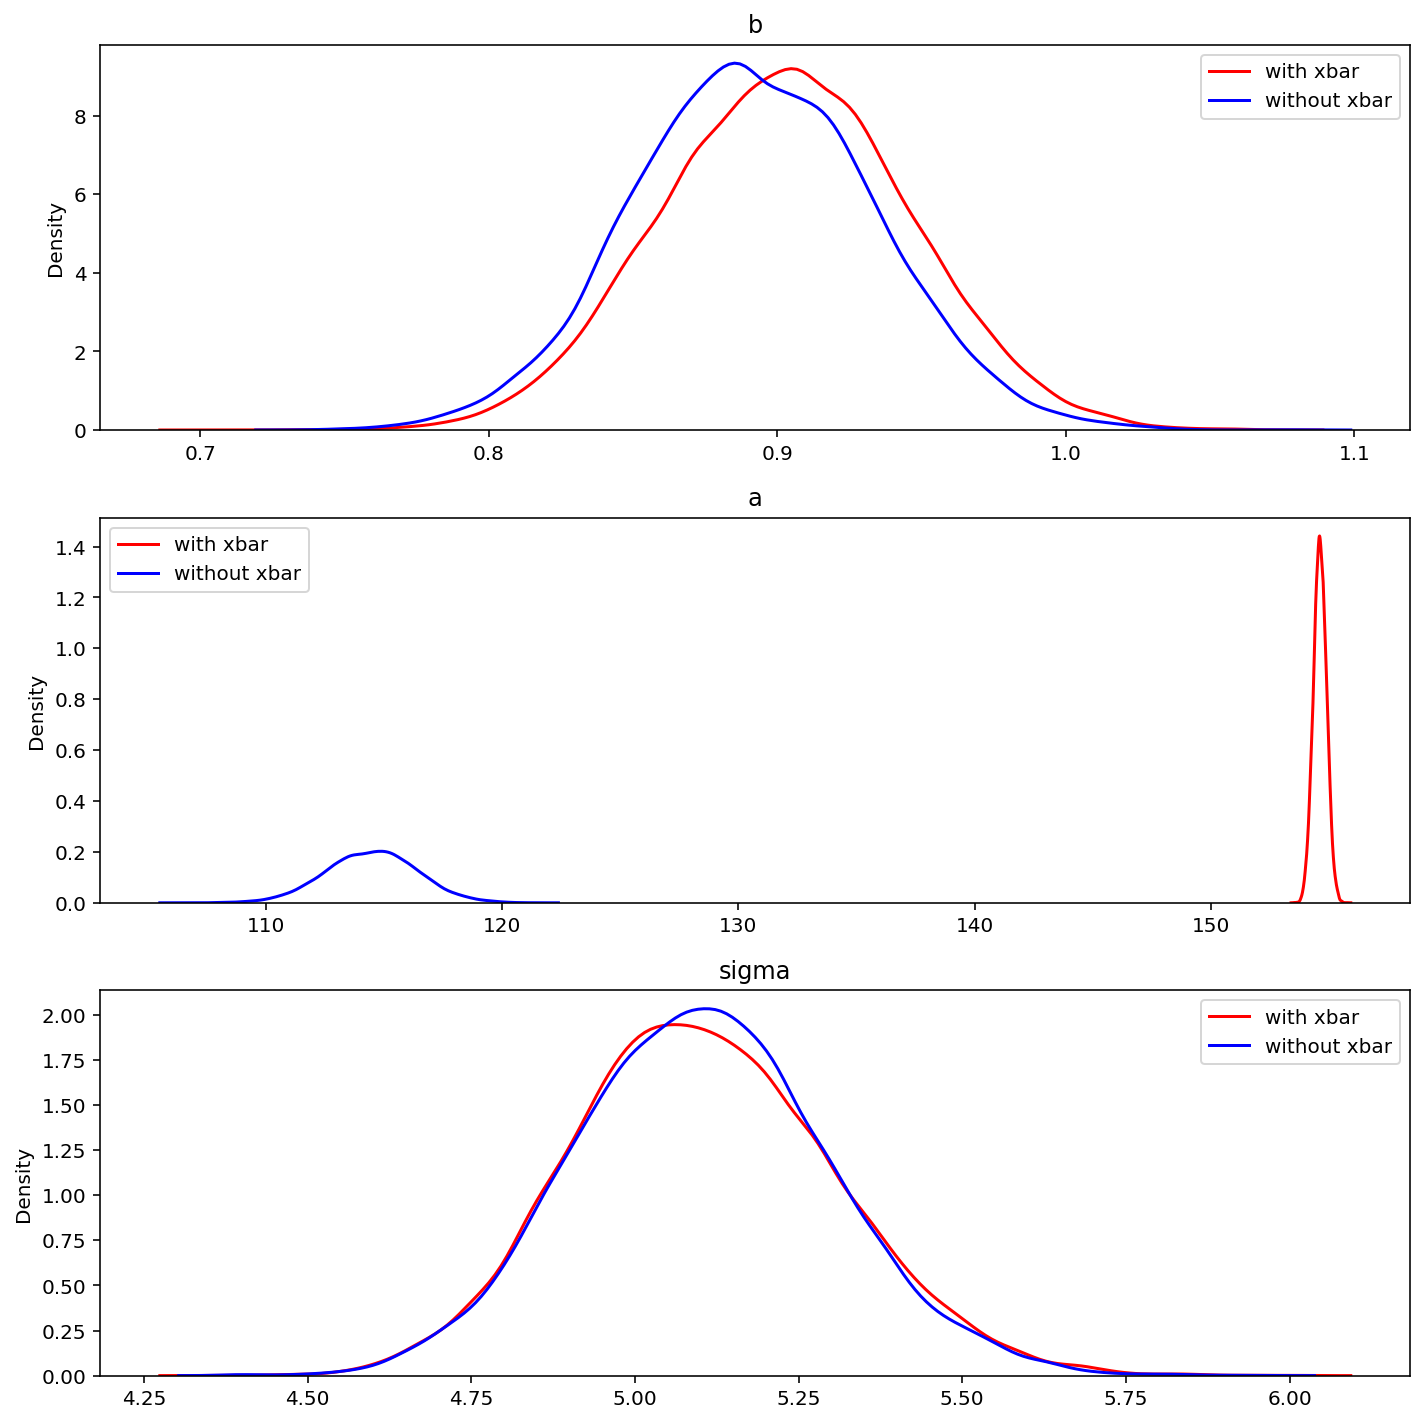

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

sns.kdeplot(trace_with_xbar['b'], ax=ax1, label='with xbar', color='red')
sns.kdeplot(trace_without_xbar['b'], ax=ax1, label='without xbar', color='blue')
ax1.legend()
ax1.set_title('b')

sns.kdeplot(trace_with_xbar['a'], ax=ax2, label='with xbar', color='red')
sns.kdeplot(trace_without_xbar['a'], ax=ax2, label='without xbar', color='blue')
ax2.legend()
ax2.set_title('a')

sns.kdeplot(trace_with_xbar['sigma'], ax=ax3, label='with xbar', color='red')
sns.kdeplot(trace_without_xbar['sigma'], ax=ax3, label='without xbar', color='blue')
ax3.legend()
ax3.set_title('sigma')

fig.tight_layout()
plt.show()

In [9]:
xgrid = np.linspace(d2['weight'].min(), d2['weight'].max(), 100)

In [10]:
def predict_univariate(trace, weight_grid):
    mu = []

    for w in weight_grid:
        mux = trace['a'] + trace['b'] * w
        mu.append(mux)

    mu = np.array(mu).T
    return mu

mu_with_xbar = predict_univariate(trace_with_xbar, xgrid - xbar)
mu_without_xbar = predict_univariate(trace_without_xbar, xgrid)

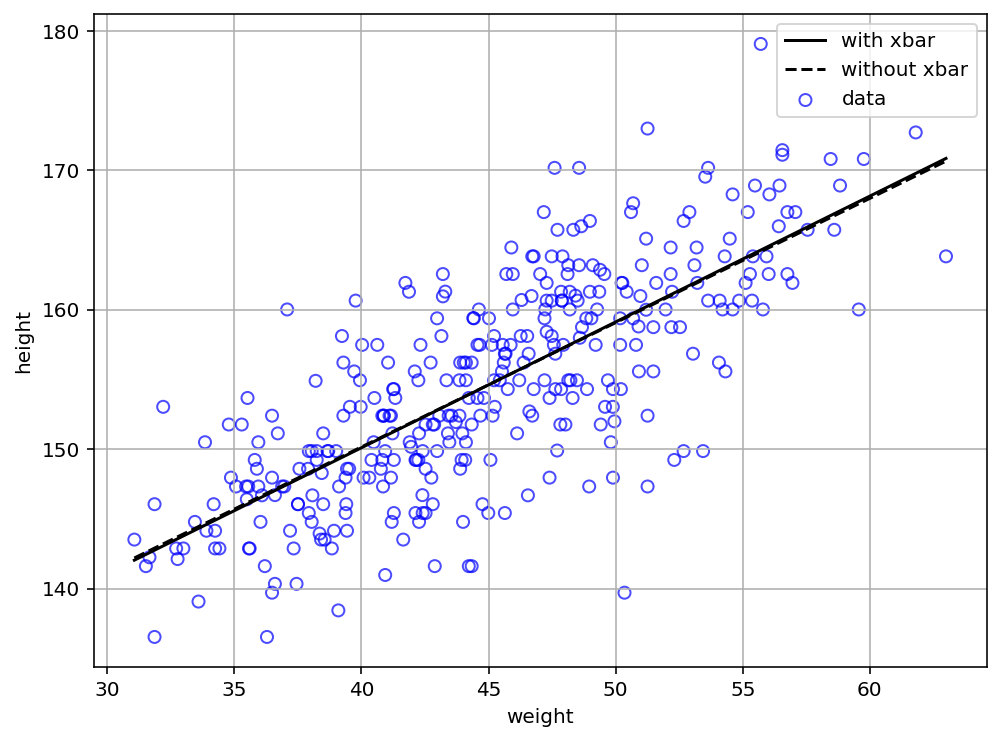

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(d2['weight'], d2['height'], facecolors='none', edgecolors='blue', alpha=.7, label='data')
ax.plot(xgrid, mu_with_xbar.mean(axis=0), label='with xbar', color='k')
ax.plot(xgrid, mu_without_xbar.mean(axis=0), label='without xbar', color='k', linestyle='--')
ax.grid()
ax.legend()
ax.set_xlabel('weight')
ax.set_ylabel('height')


plt.show()

The $\alpha$ parameter got much smaller, but othen than that, the results were very close

### 4M8. 

In the chapter, we used 15 knots with the cherry blossom spline. Increase the number of knots and observe what happens to the resulting spline. Then adjust also the width of the prior on the weights—change the standard deviation of the prior and watch what happens. What do you think the combination of knot number and the prior on the weights controls?

In [12]:
d = pd.read_csv('../../data/cherry_blossoms.csv')

In [13]:
d2 = d[d['doy'].notna()].reset_index(drop=True)

In [14]:
def run_spline_regression(df: pd.DataFrame, num_knots: int):
    knot_list = np.quantile(df['year'], q=np.linspace(0, 1, num_knots))
    B = bs(df['year'], knots=knot_list[1:-1], degree=3, include_intercept=True).values
    
    with pm.Model() as model:
        a = pm.Normal('a', mu=100, sigma=10)
        sigma = pm.Exponential('sigma', lam=1)
        w = pm.Normal('w', mu=0, sigma=10, shape=B.shape[1])
        mu = pm.Deterministic('mu', a + pm.math.dot(B, w.T))
        D = pm.Normal('D', mu=mu, sigma=sigma, observed=df['doy'])
        trace = pm.sample(5000, tune=10000)
    
    return B, model, trace

In [15]:
num_knots_tries = [5, 10, 15, 20, 25]
results = []

for num_knots in num_knots_tries:
    result = run_spline_regression(d2, num_knots)
    results.append(result)

<ipython-input-14-a95399e53fbb>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, tune=10000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, sigma, a]


Sampling 2 chains for 10_000 tune and 5_000 draw iterations (20_000 + 10_000 draws total) took 155 seconds.
The number of effective samples is smaller than 25% for some parameters.
<ipython-input-14-a95399e53fbb>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, tune=10000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, sigma, a]


Sampling 2 chains for 10_000 tune and 5_000 draw iterations (20_000 + 10_000 draws total) took 156 seconds.
The acceptance probability does not match the target. It is 0.8810432435327675, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
<ipython-input-14-a95399e53fbb>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, tune=10000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, sigma, a]


Sampling 2 chains for 10_000 tune and 5_000 draw iterations (20_000 + 10_000 draws total) took 143 seconds.
There were 1208 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6411985685913804, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
<ipython-input-14-a95399e53fbb>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, tune=10000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, sigma, a]


Sampling 2 chains for 10_000 tune and 5_000 draw iterations (20_000 + 10_000 draws total) took 157 seconds.
There were 370 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6814931398056095, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
<ipython-input-14-a95399e53fbb>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, tune=10000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, sigma, a]


Sampling 2 chains for 10_000 tune and 5_000 draw iterations (20_000 + 10_000 draws total) took 125 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


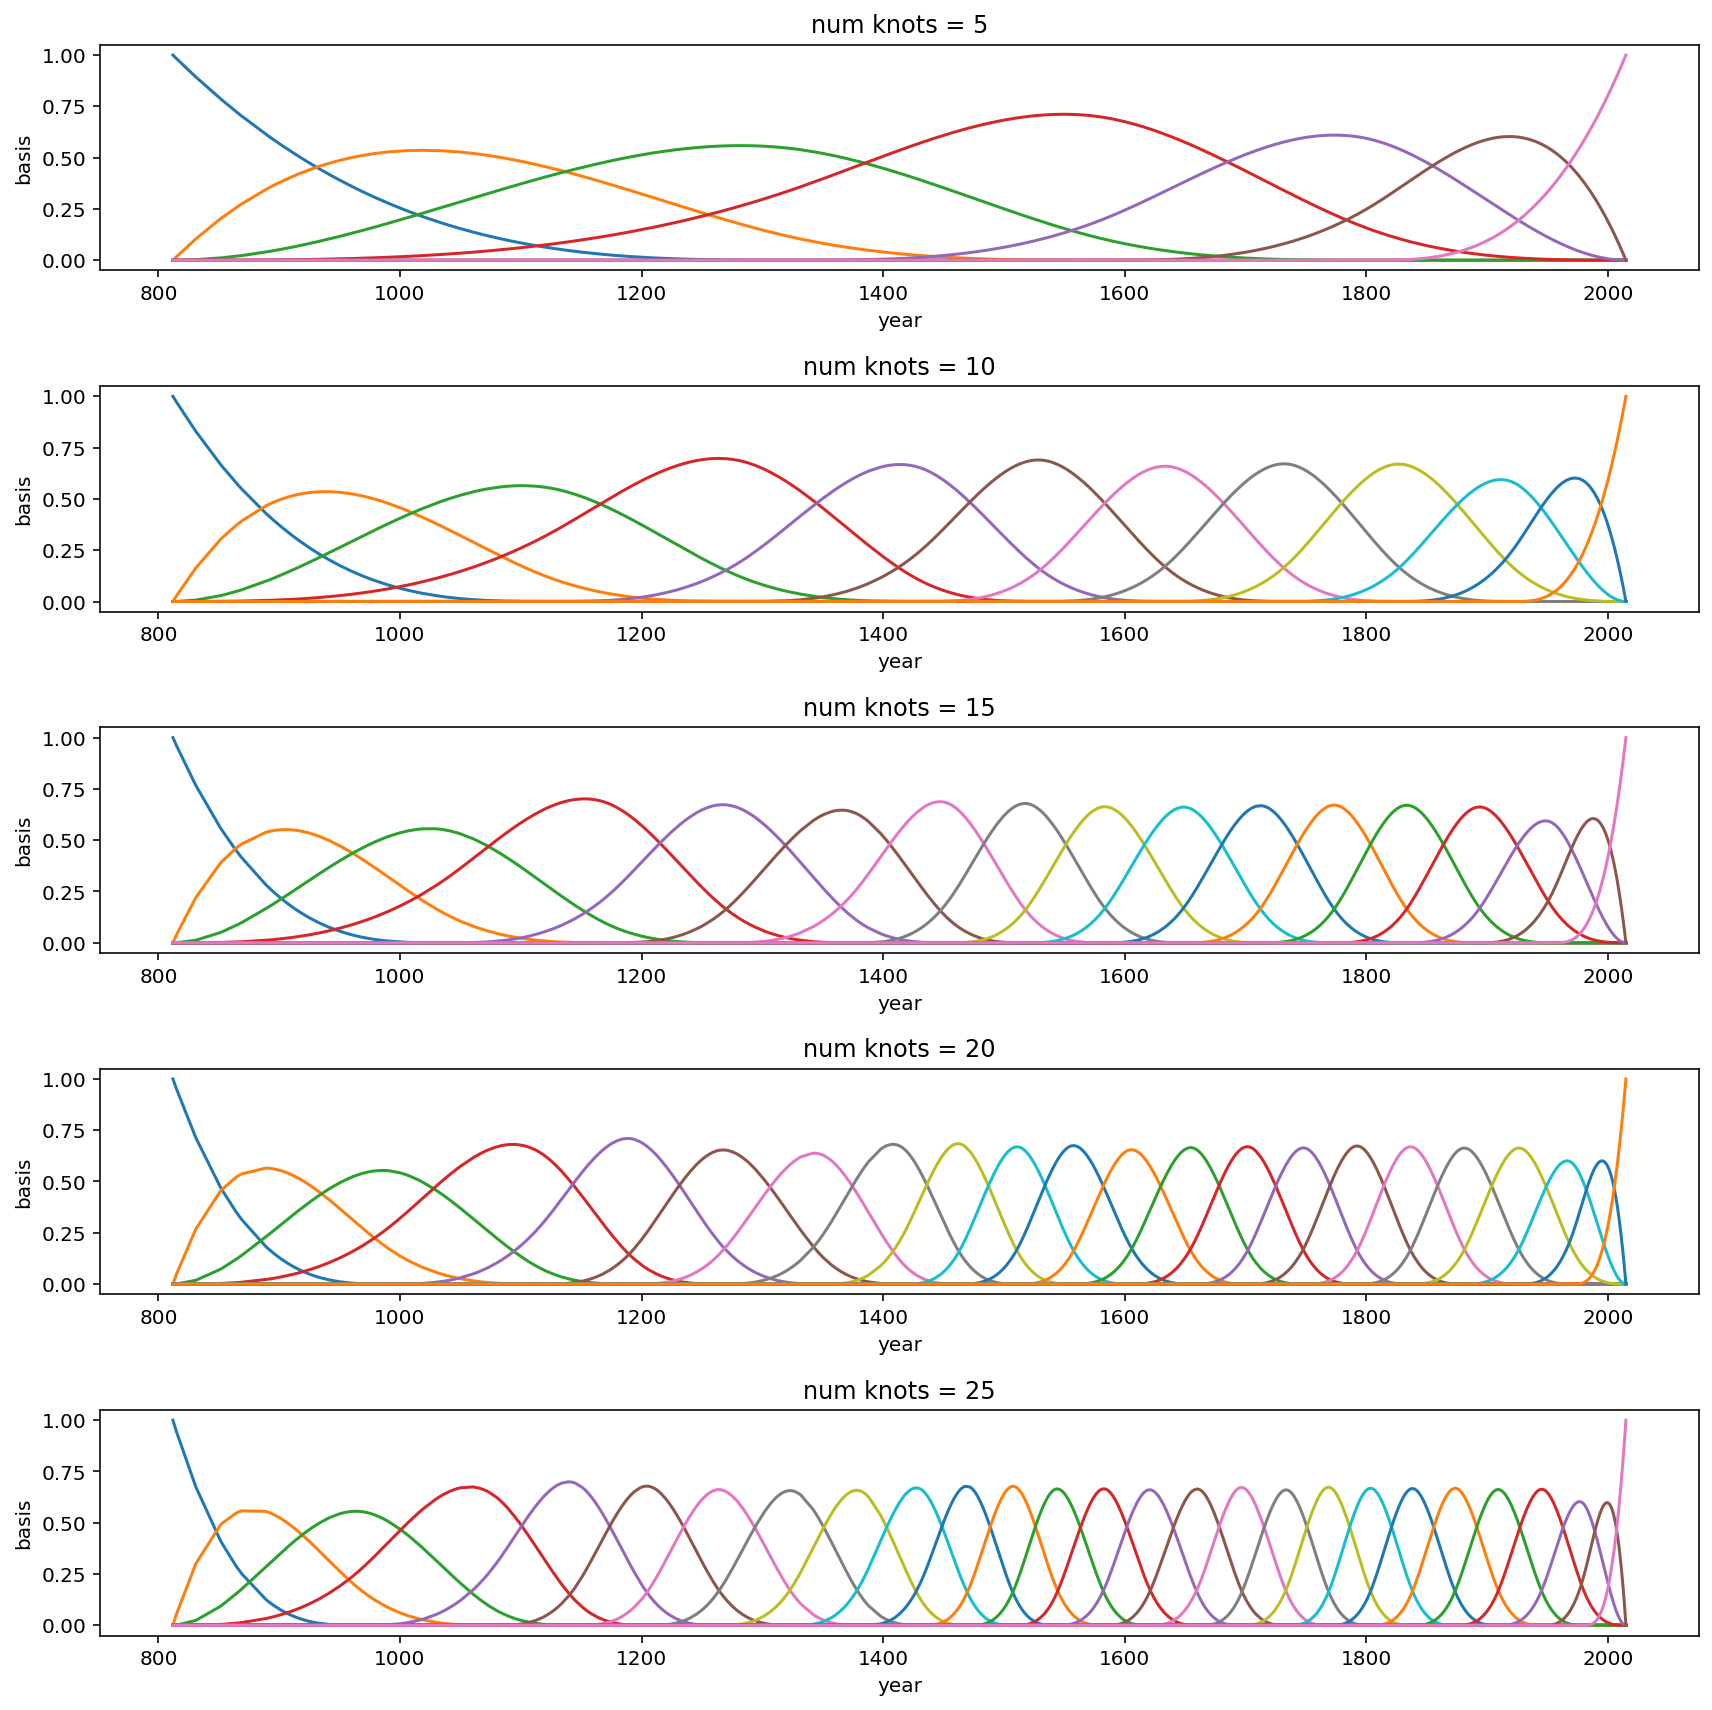

In [16]:
fig, axes = plt.subplots(len(num_knots_tries), figsize=(12, 12))

for num_knots, ax, (B, _, _) in zip(num_knots_tries, axes, results):
    for i in range(B.shape[1]):
        ax.plot(d2['year'], (B[:, i]))

    ax.set_xlabel("year")
    ax.set_ylabel("basis")
    ax.set_title(f'num knots = {num_knots}')
    
fig.tight_layout()
plt.show()

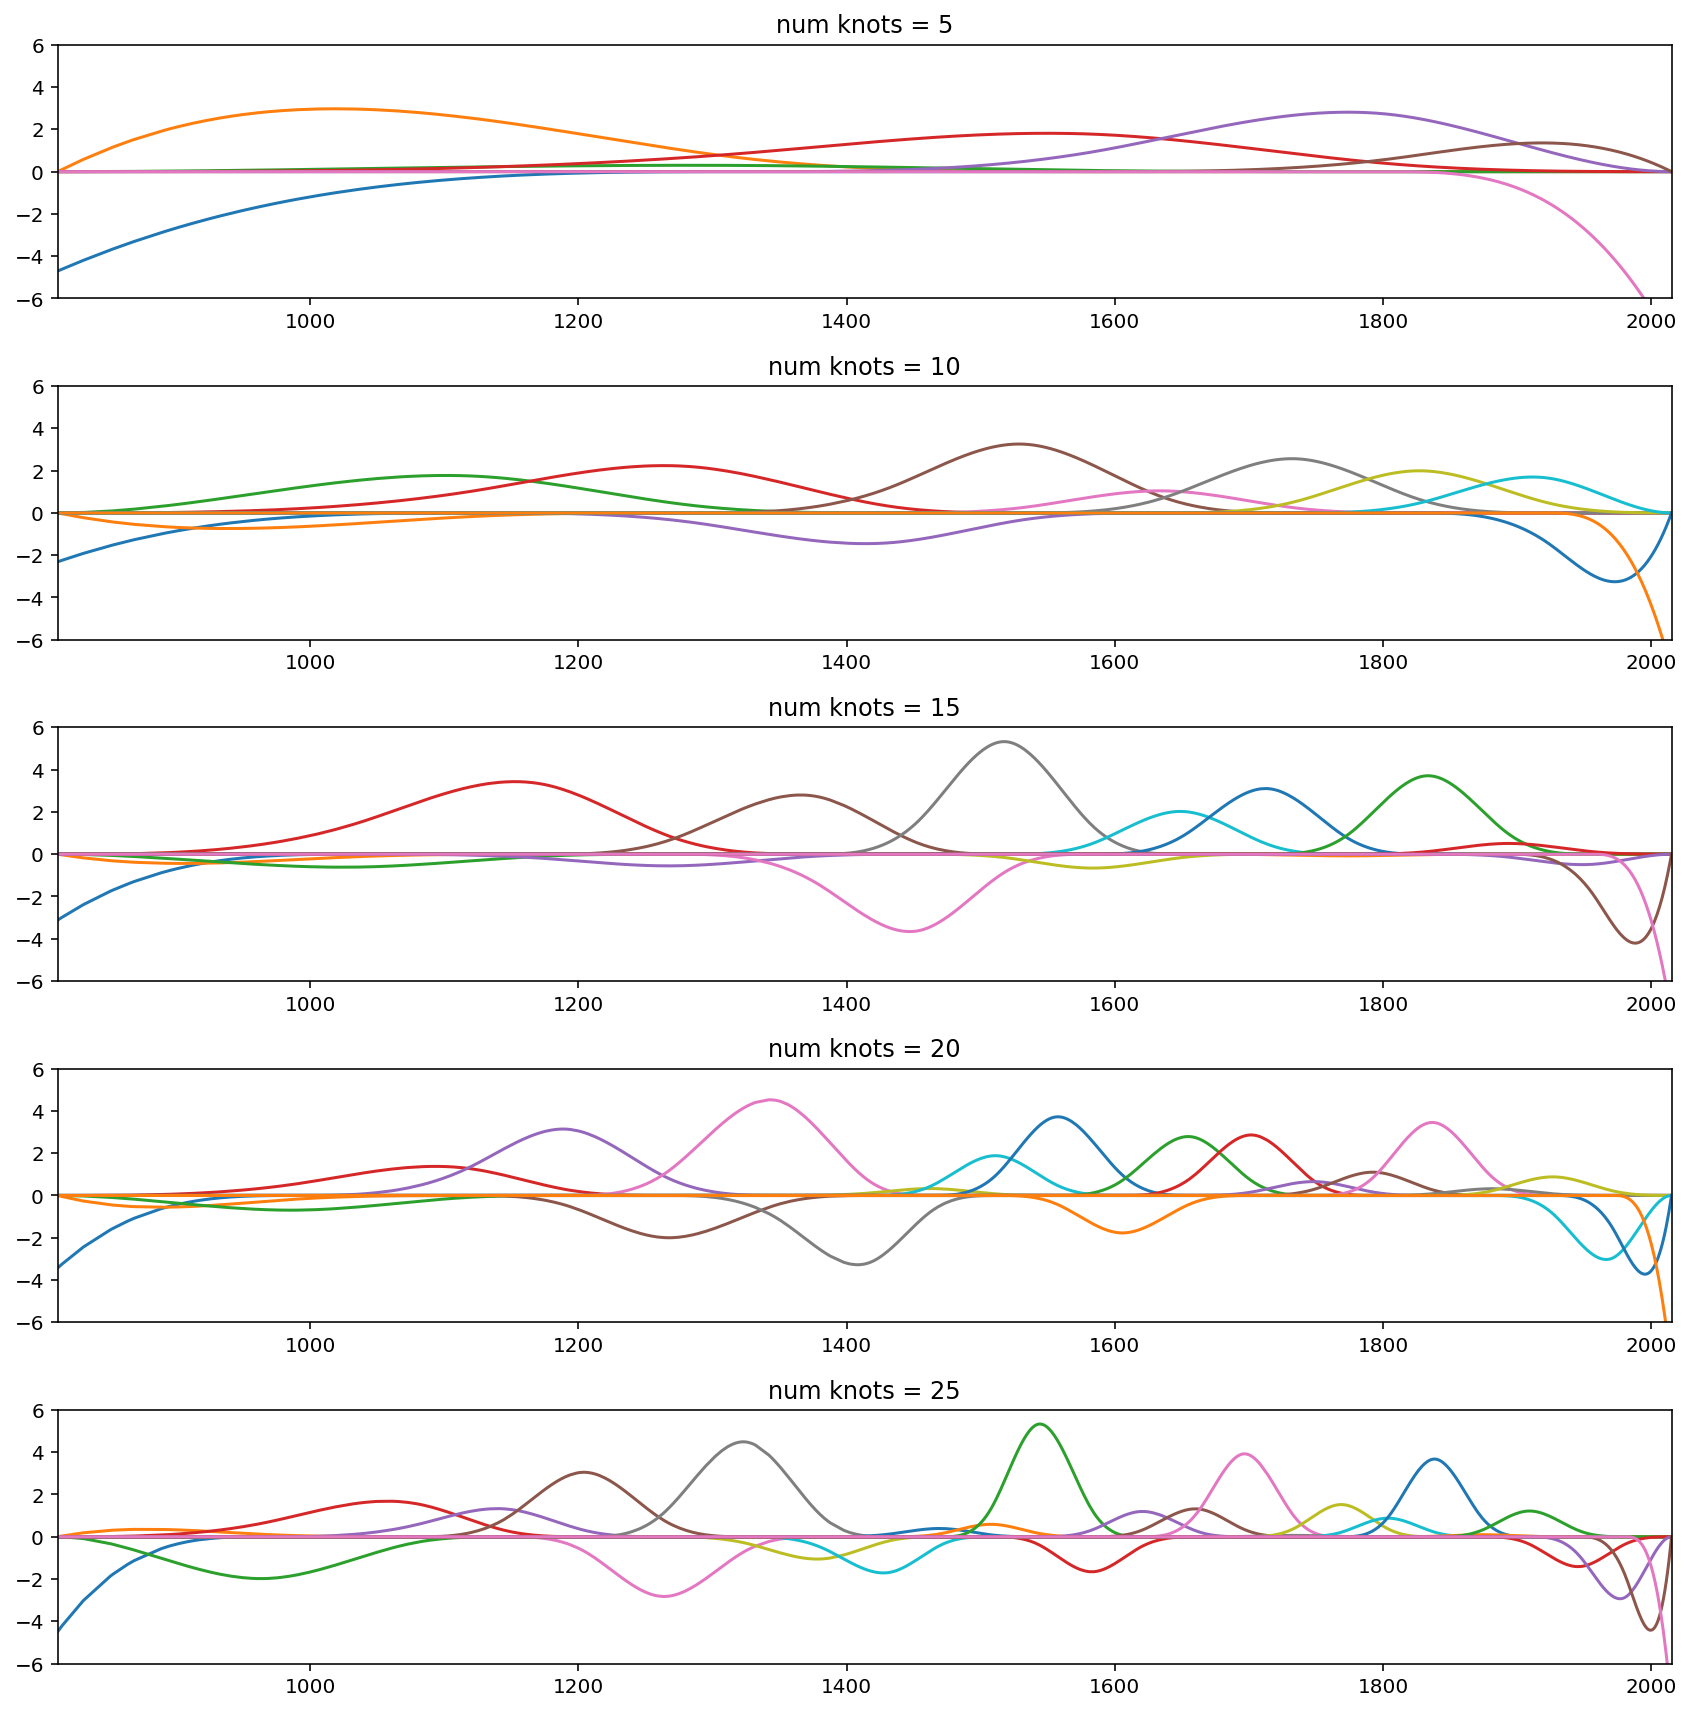

In [17]:
fig, axes = plt.subplots(len(num_knots_tries), figsize=(12, 12))

for num_knots, ax, (B, _, trace) in zip(num_knots_tries, axes, results):
    wp = trace['w'].mean(0)
    for i in range(B.shape[1]):
        ax.plot(d2['year'], (wp[i] * B[:, i]))

    ax.set_xlim(812, 2015)
    ax.set_ylim(-6, 6);
    ax.set_title(f'num knots = {num_knots}')
    
fig.tight_layout()
plt.show()

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/s

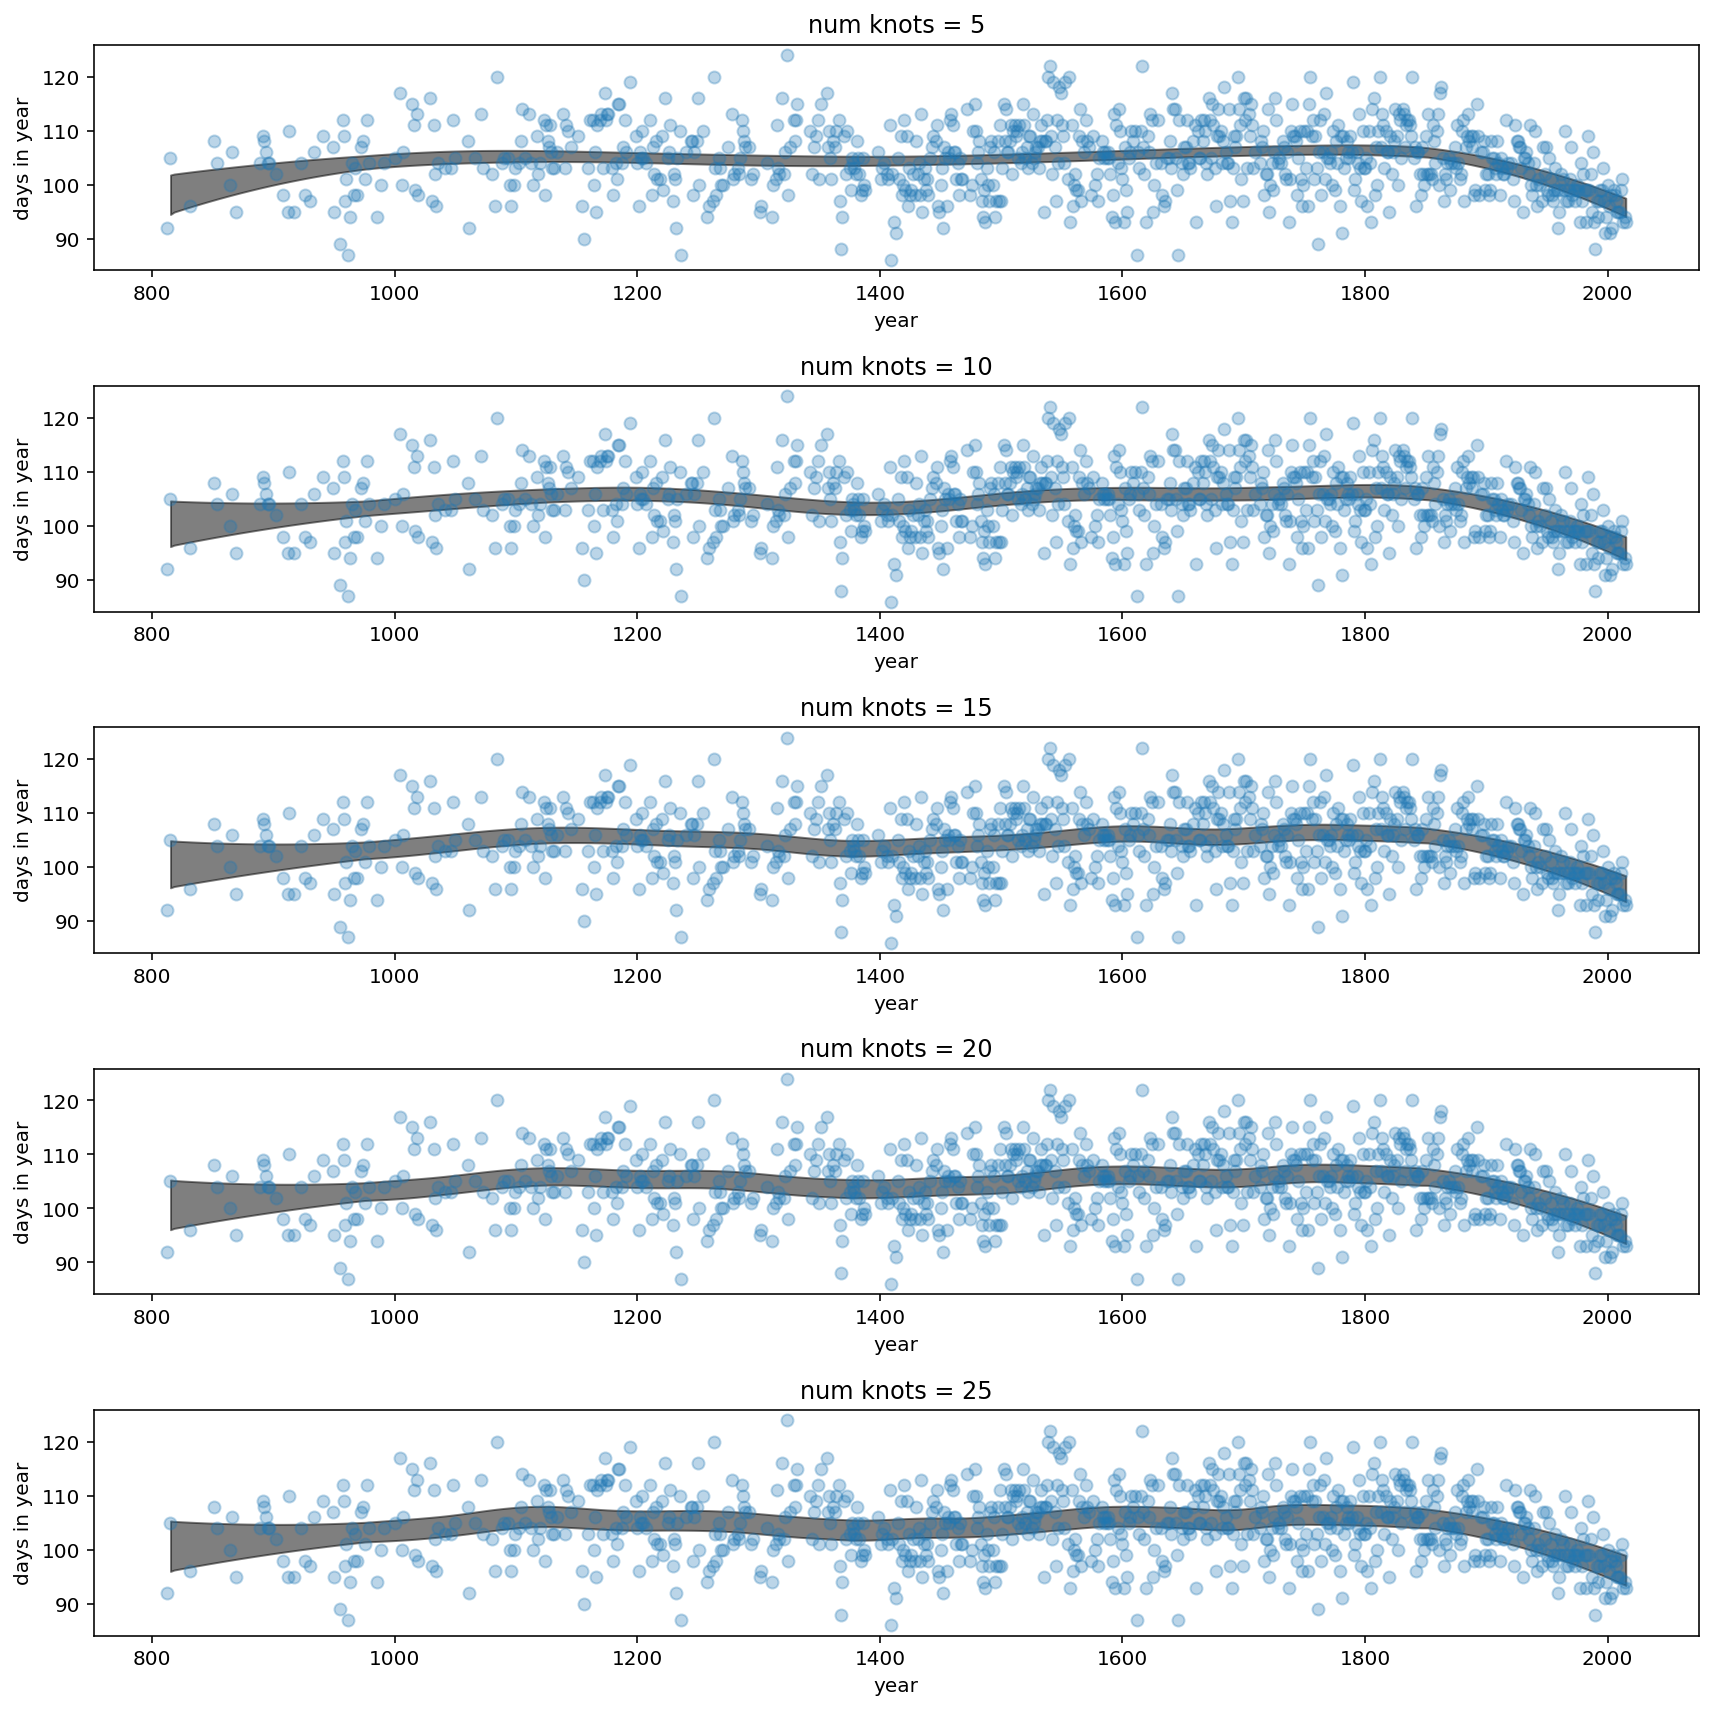

In [18]:
fig, axes = plt.subplots(len(num_knots_tries), figsize=(12, 12))

for num_knots, ax, (B, _, trace) in zip(num_knots_tries, axes, results):
    az.plot_hdi(d2['year'], trace["mu"], color="k", ax=ax)
    ax.plot(d2['year'], d2['doy'], "o", alpha=0.3)
    ax.set_xlabel("year")
    ax.set_ylabel("days in year")
    ax.set_title(f'num knots = {num_knots}')
    
fig.tight_layout()
plt.show()

### 4H1.

The weights listed below were recorded in the !Kung census, but heights were not recorded for these individuals. Provide predicted heights and 89% intervals for each of these individuals. That is, fill in the table below, using model-based predictions.


| Individual | Weight | Expected Height | 89% Interval |
|:----------:|:------:|:---------------:|:------------:|
|1           |46.95   |
|2           |43.72   |
|3           |64.78   |
|4           |32.59   |
|5           |54.63   |

In [19]:
not_rec = pd.DataFrame({'weight': [46.95, 43.72, 64.78, 32.59, 54.63]})

In [20]:
d = pd.read_csv('../../data/Howell1.csv', sep=';')

In [21]:
d['weight_s'] = (d['weight'] - d['weight'].mean()) / d['weight'].std()
d['weight_s2'] = d['weight_s'] ** 2
d['weight_s3'] = d['weight_s'] ** 3

In [22]:
with pm.Model() as model:
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    a = pm.Normal('a', mu=178, sigma=20)
    b1 = pm.Lognormal('b1', mu=0, sigma=1)
    b2 = pm.Normal('b2', mu=0, sigma=1)
    b3 = pm.Normal('b3', mu=0, sigma=1)
    
    mu = a + b1*d['weight_s'] + b2*d['weight_s2'] + b3*d['weight_s3']
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d['height'])
    
    trace = pm.sample(10000, tune=1000)    

<ipython-input-22-08d841d1923d>:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b3, b2, b1, a, sigma]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 37 seconds.


In [23]:
not_rec['weight_s'] = (not_rec['weight'] - d['weight'].mean()) / d['weight'].std()
not_rec['weight_s2'] = not_rec['weight_s'] ** 2
not_rec['weight_s3'] = not_rec['weight_s'] ** 3

In [24]:
not_rec['expected_height'] = np.NaN
not_rec['89_interval_lower'] = np.NaN
not_rec['89_interval_upper'] = np.NaN

In [25]:
for i, row in not_rec.iterrows():
    mu = trace['a'] + \
        trace['b1'] * row['weight_s'] + \
        trace['b2'] * row['weight_s2'] + \
        trace['b3'] * row['weight_s3']
    sim = stats.norm(mu, trace['sigma']).rvs()
    interval = az.hdi(sim, hdi_prob=.89)
    
    not_rec.loc[i, 'expected_height'] = mu.mean()
    not_rec.loc[i, '89_interval_lower'] = interval[0]
    not_rec.loc[i, '89_interval_upper'] = interval[1]

In [26]:
not_rec

weight  weight_s  weight_s2  weight_s3  expected_height  89_interval_lower  \
0   46.95  0.770381   0.593488   0.457212       156.077451         148.178838   
1   43.72  0.550940   0.303535   0.167229       153.494640         145.628660   
2   64.78  1.981726   3.927239   7.782713       180.101596         171.954692   
3   32.59 -0.205216   0.042114  -0.008642       142.972781         135.326908   
4   54.63  1.292150   1.669651   2.157439       163.442668         155.415247   

   89_interval_upper  
0         163.892828  
1         161.308924  
2         188.544740  
3         150.895533  
4         171.051094

### 4H2. 
Select out all the rows in the Howell1 data with ages below 18 years of age. If you do it right, you should end up with a new data frame with 192 rows in it.

**(a)** Fit a linear regression to these data, using quap. Present and interpret the estimates. For every 10 units of increase in weight, how much taller does the model predict a child gets?

**(b)** Plot the raw data, with height on the vertical axis and weight on the horizontal axis. Superimpose the MAP regression line and 89% interval for the mean. Also superimpose the 89% interval for predicted heights.

**(c)** What aspects of the model fit concern you? Describe the kinds of assumptions you would change, if any, to improve the model. You don’t have to write any new code. Just explain what the model appears to be doing a bad job of, and what you hypothesize would be a better model.

In [27]:
d = pd.read_csv('../../data/Howell1.csv', sep=';')
d = d[d['age'] < 18].reset_index(drop=True)
len(d)

192

In [28]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', d['weight'].mean(), 20)
    beta = pm.Lognormal('beta', 0, 1)
    sigma = pm.Exponential('sigma', 1)
    mu = alpha + beta * (d['weight'] - d['weight'].mean())
    height = pm.Normal('height', mu, sigma, observed=d['height'])
    trace = pm.sample(1000, tune=1000)

<ipython-input-28-0c9537f40e4a>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


In [29]:
az.summary(trace, hdi_prob=.89, kind='stats')

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_5.5%  hdi_94.5%
alpha  108.236  0.612   107.239    109.227
beta     2.716  0.072     2.605      2.824
sigma    8.366  0.429     7.726      9.092

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


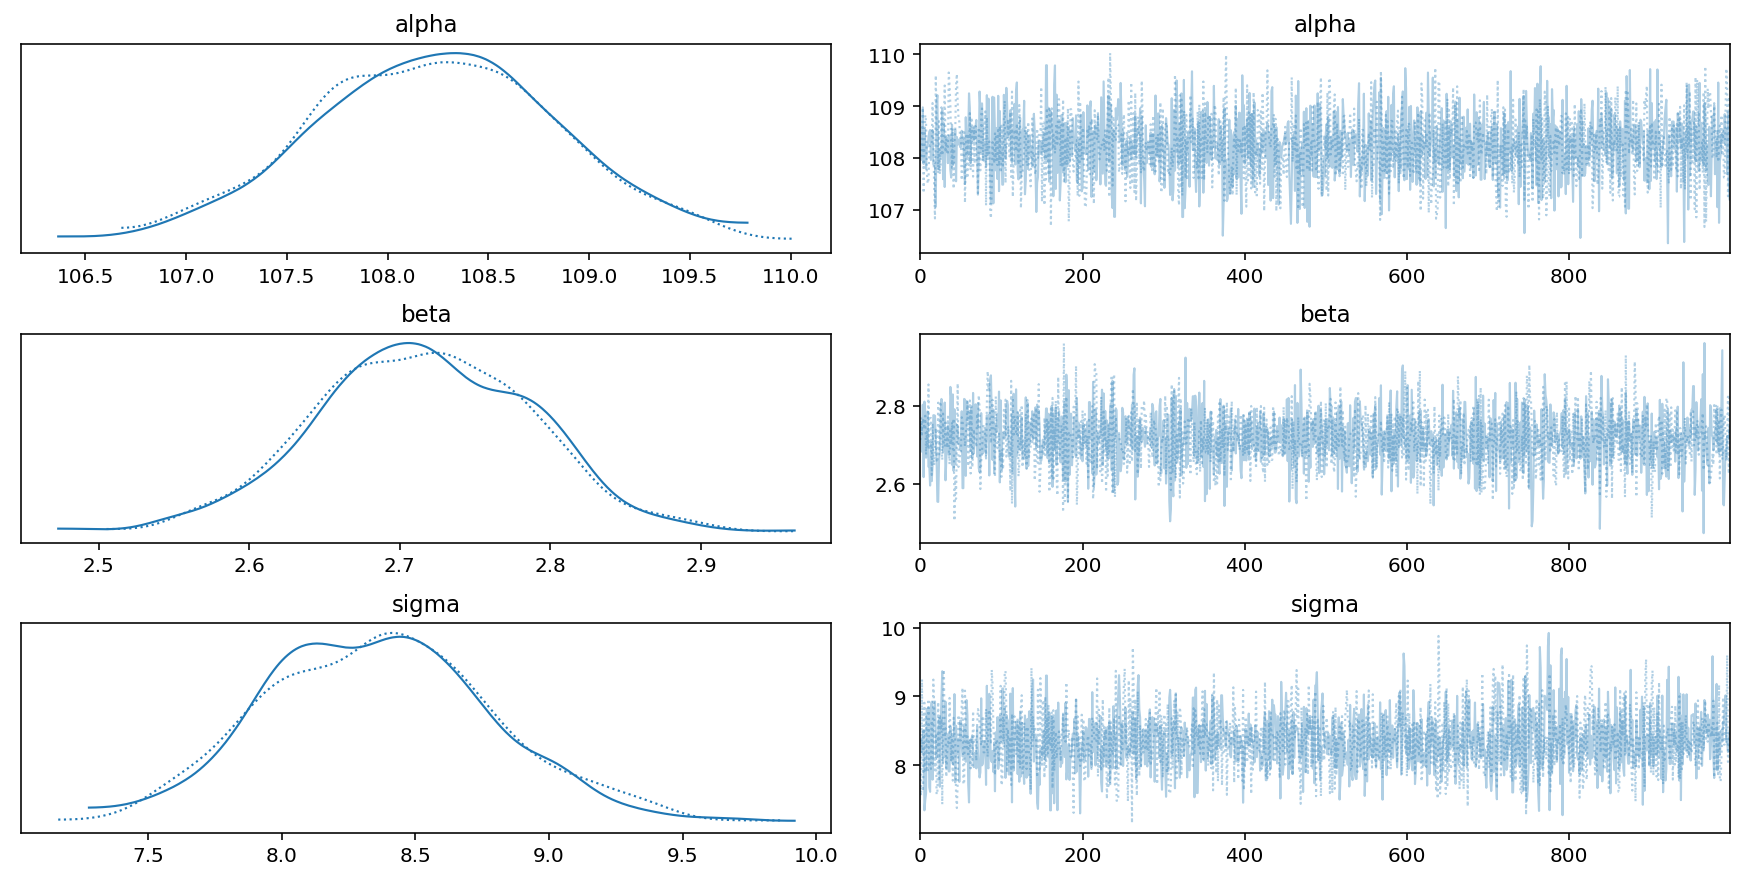

In [30]:
az.plot_trace(trace)
plt.show()

In [31]:
weight_grid = np.linspace(d['weight'].min(), d['weight'].max(), 30)

mu = []
sim = []

for w in weight_grid:
    muw = trace['alpha'] + trace['beta'] * (w - d['weight'].mean())
    simw = stats.norm(muw, trace['sigma']).rvs()

    mu.append(muw)
    sim.append(simw)

mu = np.array(mu).T
sim = np.array(sim).T
muci = az.hdi(mu, hdi_prob=.89)
ci = az.hdi(sim, hdi_prob=.89)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


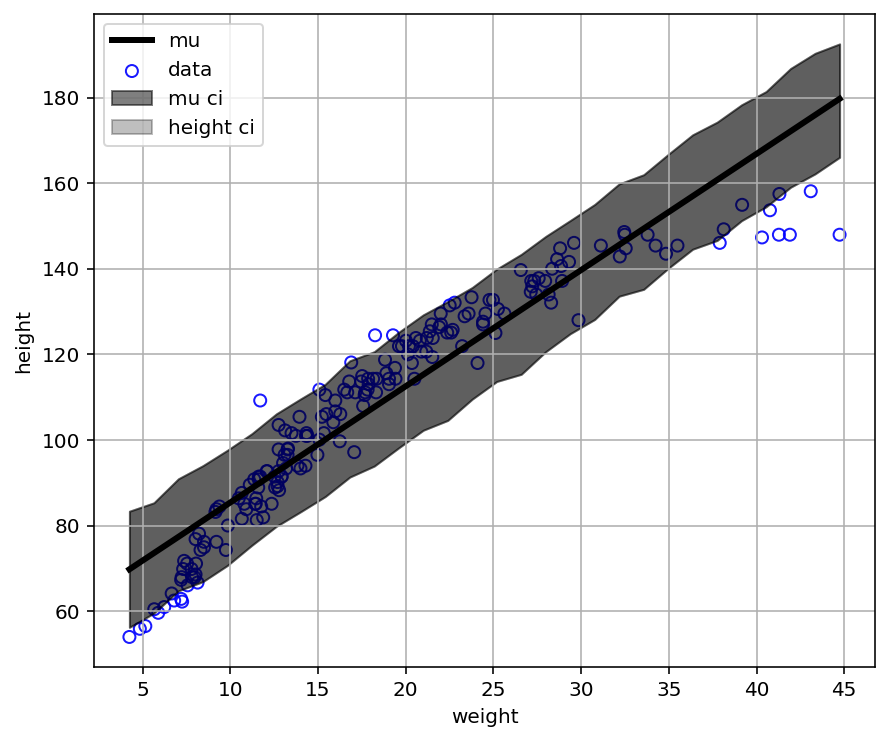

In [32]:
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(d['weight'], d['height'], facecolors='none', edgecolors='blue', alpha=.9, label='data')
ax.plot(weight_grid, mu.mean(axis=0), color='black', linewidth=3, label='mu')
ax.fill_between(weight_grid, ci[:, 0], ci[:, 1], alpha=.5, color='black', label='mu ci')
ax.fill_between(weight_grid, ci[:, 0], ci[:, 1], alpha=.25, color='black', label='height ci')
ax.grid()
ax.set_xlabel('weight')
ax.set_ylabel('height')
ax.legend()
plt.show()

Would probably not use a linear model. Poly 2 or 3 would be fine

In [33]:
d['weight_norm'] = (d['weight'] - d['weight'].mean()) / d['weight'].std()
d['weight_norm_2'] = d['weight_norm'] ** 2

In [34]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', d['height'].mean(), 20)
    beta1 = pm.Lognormal('beta1', 0, 1)
    beta2 = pm.Normal('beta2', 0, 1)
    sigma = pm.Exponential('sigma', 1)
    mu = alpha + beta1 * d['weight_norm'] + beta2 * d['weight_norm_2']
    height = pm.Normal('height', mu, sigma, observed=d['height'])
    trace = pm.sample(1000, tune=1000)

<ipython-input-34-18d5819f425b>:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta2, beta1, alpha]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.


In [35]:
az.summary(trace, hdi_prob=.89, kind='stats')

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_5.5%  hdi_94.5%
alpha  113.845  0.385   113.203    114.434
beta2   -5.565  0.241    -5.918     -5.169
beta1   28.864  0.358    28.324     29.472
sigma    4.295  0.220     3.942      4.630

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


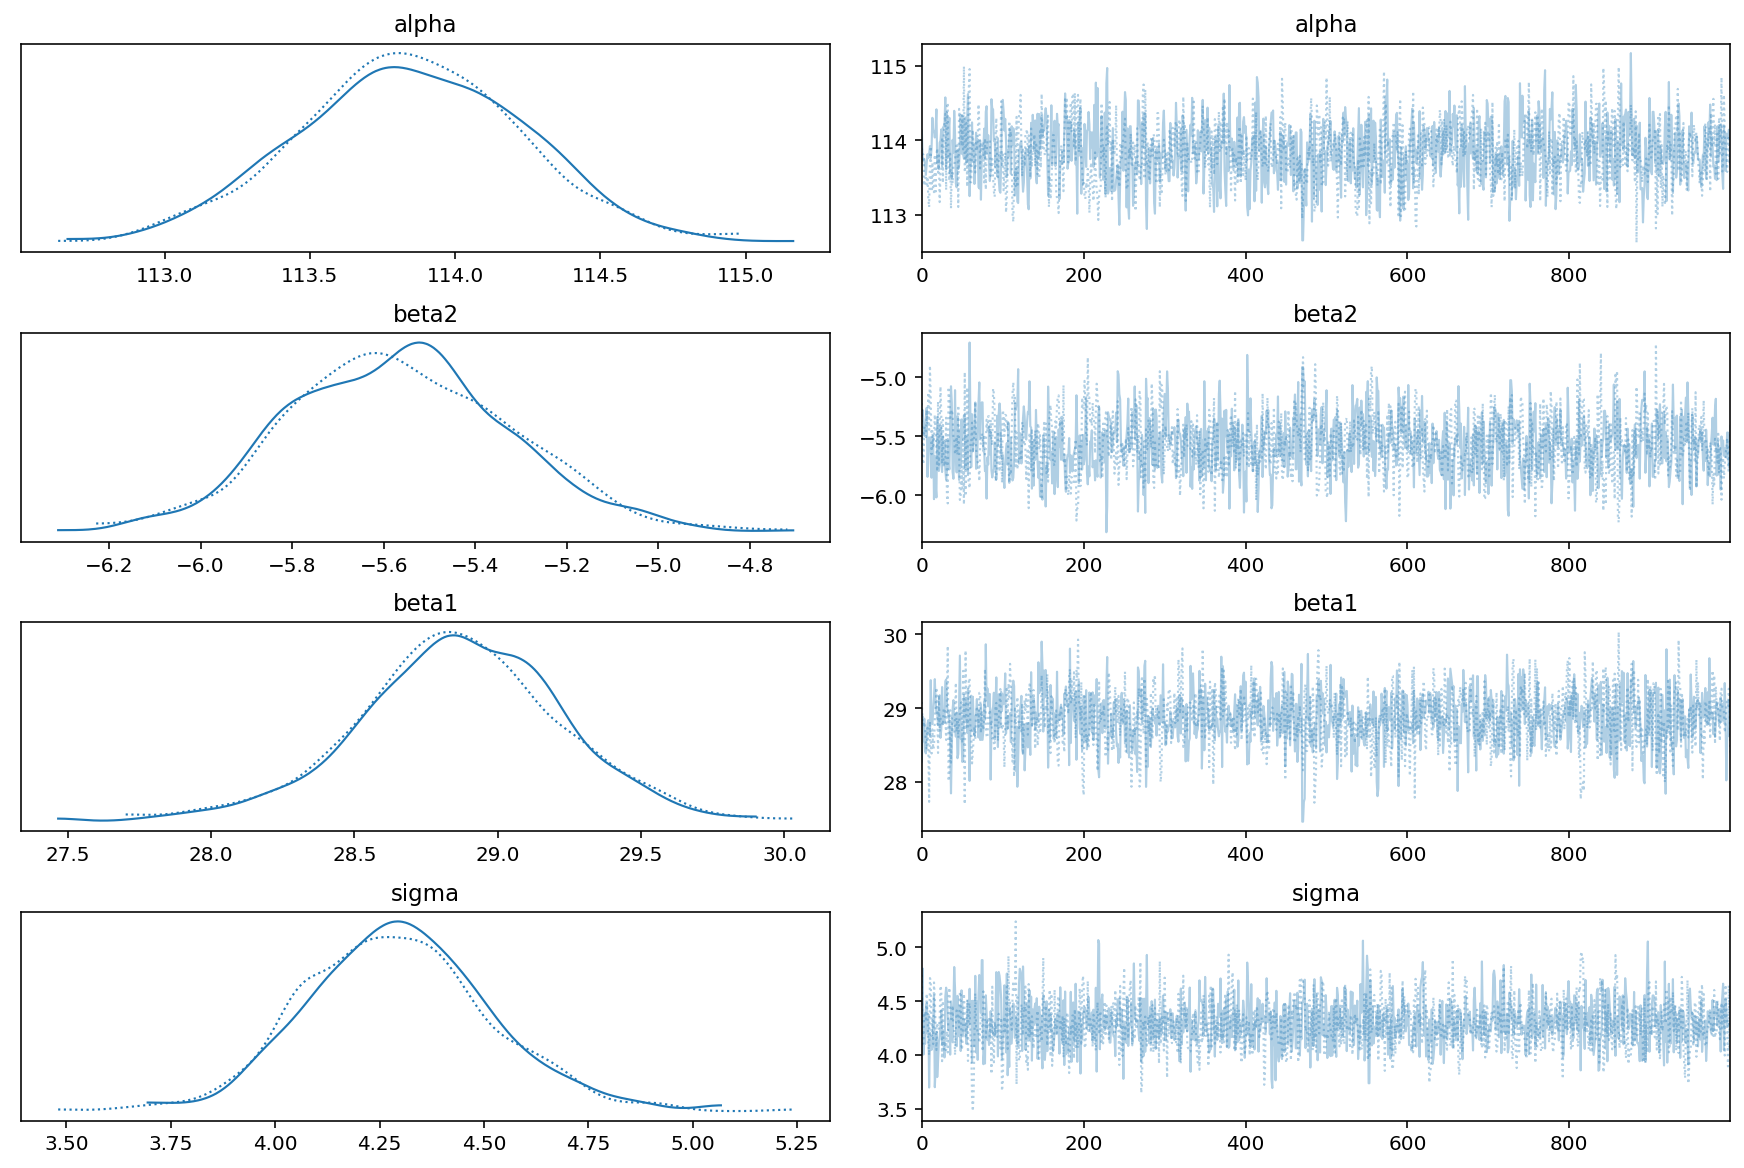

In [36]:
az.plot_trace(trace)
plt.show()

In [37]:
weight_grid = np.linspace(d['weight_norm'].min(), d['weight_norm'].max(), 30)

mu = []
sim = []

for w in weight_grid:
    muw = trace['alpha'] + trace['beta1'] * w + trace['beta2'] * w**2
    simw = stats.norm(muw, trace['sigma']).rvs()

    mu.append(muw)
    sim.append(simw)

mu = np.array(mu).T
sim = np.array(sim).T
muci = az.hdi(mu, hdi_prob=.89)
ci = az.hdi(sim, hdi_prob=.89)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


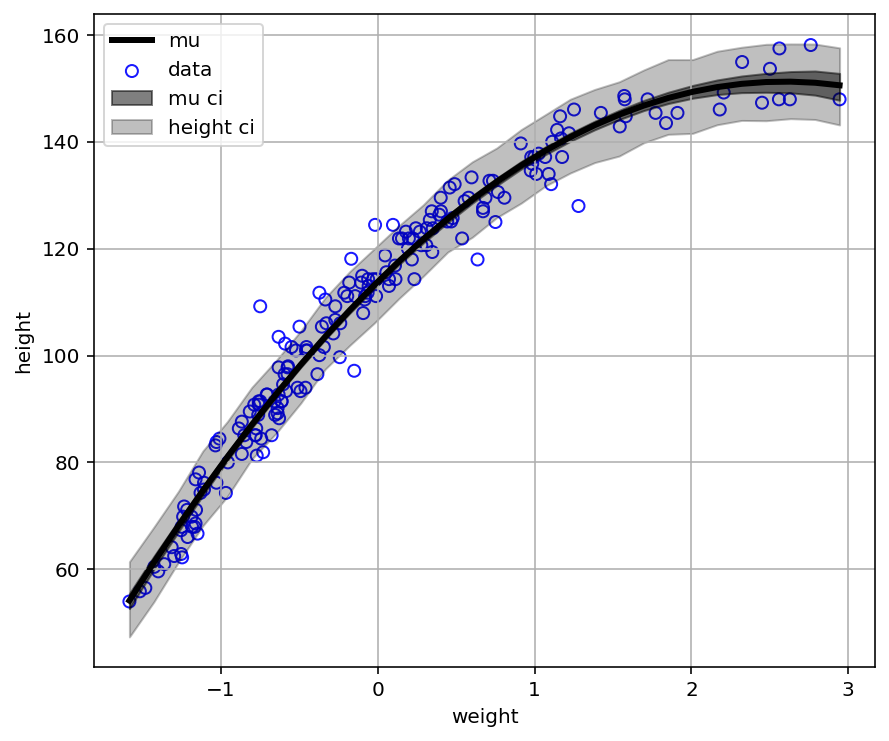

In [38]:
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(d['weight_norm'], d['height'], facecolors='none', edgecolors='blue', alpha=.9, label='data')
ax.plot(weight_grid, mu.mean(axis=0), color='black', linewidth=3, label='mu')
ax.fill_between(weight_grid, muci[:, 0], muci[:, 1], alpha=.5, color='black', label='mu ci')
ax.fill_between(weight_grid, ci[:, 0], ci[:, 1], alpha=.25, color='black', label='height ci')
ax.grid()
ax.set_xlabel('weight')
ax.set_ylabel('height')
ax.legend()
plt.show()

### 4H3. 
Suppose a colleague of yours, who works on allometry, glances at the practice problems just above. Your colleague exclaims, “That’s silly. Everyone knows that it’s only the logarithm of body weight that scales with height!” Let’s take your colleague’s advice and see what happens.

**(a)** Model the relationship between height (cm) and the natural logarithm of weight (log-kg). Use the entire Howell1 data frame, all 544 rows, adults and non-adults. Can you interpret the resulting estimates?

**(b)** Begin with this plot: `plot( height ~ weight , data=Howell1 )`. Then use samples from the quadratic approximate posterior of the model in (a) to superimpose on the plot: (1) the predicted mean height as a function of weight, (2) the 97% interval for the mean, and (3) the 97% interval for predicted heights.

In [39]:
d = pd.read_csv('../../data/Howell1.csv', sep=';')

In [40]:
d['log_weight'] = np.log(d['weight'])
log_weight_mean = d['log_weight'].mean()

In [41]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=178, sigma=20)
    beta = pm.Lognormal('beta', 0, 1)
    mu = alpha + beta * (d['log_weight'] - log_weight_mean)
    sigma = pm.Exponential('sigma', 1)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d['height'])
    trace = pm.sample(10_000, tune=5_000)

<ipython-input-41-4e5167e304e9>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10_000, tune=5_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 28 seconds.


In [42]:
weight_seq = np.linspace(d['weight'].min(), d['weight'].max(), 50)
log_weight_seq = np.log(weight_seq)

In [43]:
mu = np.array([trace['alpha'] + trace['beta'] * (log_weight - log_weight_mean) for log_weight in log_weight_seq]).T
sim = np.array([np.random.normal(mu[:, i], trace['sigma']) for i in range(len(log_weight_seq))]).T

mu_ci = az.hdi(mu, hdi_prob=.89)
sim_ci = az.hdi(sim, hdi_prob=.89)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


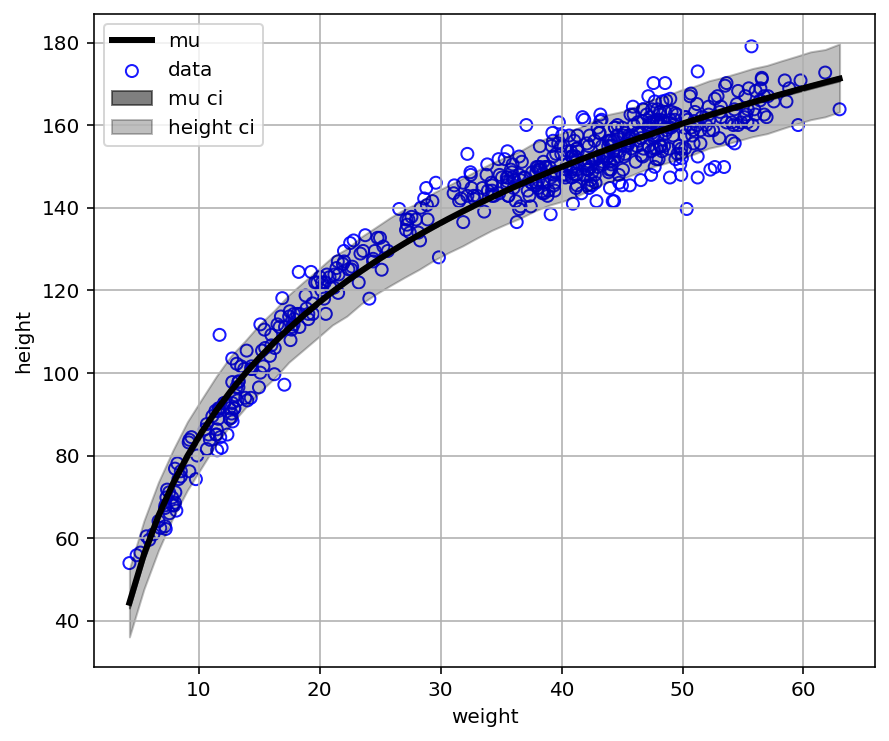

In [44]:
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(d['weight'], d['height'], facecolors='none', edgecolors='blue', alpha=.9, label='data')
ax.plot(weight_seq, mu.mean(axis=0), color='black', linewidth=3, label='mu')
ax.fill_between(weight_seq, mu_ci[:, 0], mu_ci[:, 1], alpha=.5, color='black', label='mu ci')
ax.fill_between(weight_seq, sim_ci[:, 0], sim_ci[:, 1], alpha=.25, color='black', label='height ci')
ax.grid()
ax.set_xlabel('weight')
ax.set_ylabel('height')
ax.legend()
plt.show()

### 4H4. 
Plot the prior predictive distribution for the parabolic polynomial regression model in the chapter. You can modify the code that plots the linear regression prior predictive distribution. Can you modify the prior distributions of α, β1, and β2 so that the prior predictions stay within the biologically reasonable outcome space? That is to say: Do not try to fit the data by hand. But do try to keep the curves consistent with what you know about height and weight, before seeing these exact data.

In [45]:
# Generate prior predictive checks
with pm.Model() as model:
    alpha = pm.Normal("alpha", 150, 30)
    b1 = pm.Lognormal("b1", 0, 1)
    b2 = pm.Exponential("b2", 1 / 0.05)
    sigma = pm.Uniform("sigma", 0, 1)
    mu = (
        alpha
        + b1 * (d.weight - np.mean(d.weight))
        + b2 * (d.weight - np.mean(d.weight)) ** 2
    )
    H = pm.Normal("H", mu=mu, sigma=sigma, observed=d.height)
    pp = pm.sample_prior_predictive(samples=1000)  # compute prior predictions

In [46]:
x = np.linspace(0, 70)
mh = np.mean(d.weight)
means = pp["alpha"] + np.outer(x - mh, pp["b1"]) - np.outer((x - mh) ** 2, pp["b2"])

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


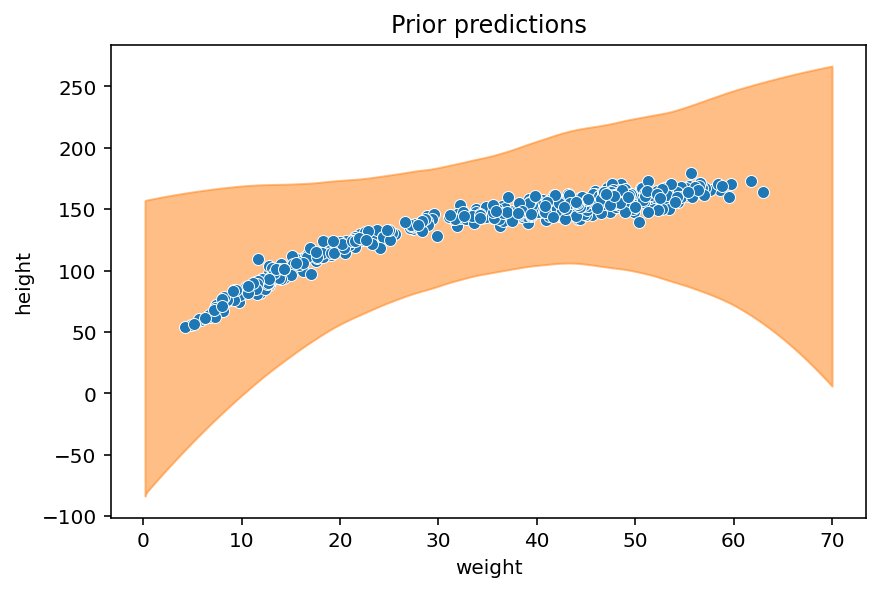

In [47]:
az.plot_hdi(x, means.T, hdi_prob=0.89)
sns.scatterplot(x="weight", y="height", data=d)
plt.title("Prior predictions");


### 4H5.
Return to `data(cherry_blossoms)` and model the association between blossom date (doy) and March temperature (temp). Note that there are many missing values in both variables. You may consider a linear model, a polynomial, or a spline on temperature. How well does temperature trend predict the blossom trend?

In [48]:
d = pd.read_csv('../../data/cherry_blossoms.csv')

In [49]:
d2 = d[['doy', 'temp']].dropna().reset_index(drop=True)

[]

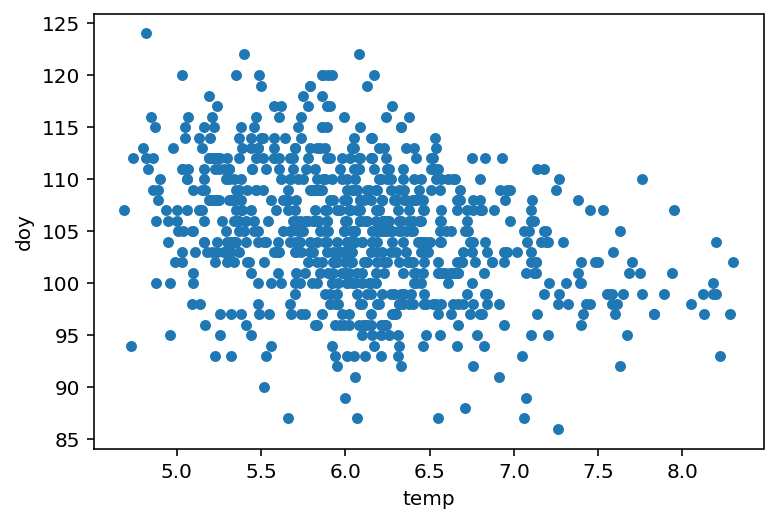

In [50]:
d2.plot.scatter(x='temp', y='doy')
plt.plot()

In [51]:
d2['temp_s'] = (d2['temp'] - d2['temp'].mean()) / d2['temp'].std()
d2['temp_s2'] = d2['temp_s'] ** 2

In [52]:
temp_s_mean = d2['temp_s'].mean()
temp_s2_mean = d2['temp_s2'].mean()

In [53]:
with pm.Model() as model:
    a = pm.Normal('a', mu=d2['doy'].mean(), sigma=20)
    b1 = pm.Normal('b1', mu=0, sigma=1)
    b2 = pm.Normal('b2', mu=0, sigma=1)
    sigma = pm.Exponential('sigma', lam=1)
    mu = a + b1 * d2['temp_s'] + b2 * d2['temp_s2']
    doy = pm.Normal('doy', mu=mu, sigma=sigma, observed=d2['doy'])
    
    trace = pm.sample(10_000, tune=5_000)

<ipython-input-53-76ed5cb8c62e>:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10_000, tune=5_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b2, b1, a]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 32 seconds.


In [54]:
temp_grid = np.linspace(d2['temp'].min(), d2['temp'].max(), 25)
temp_s_grid = (temp_grid - d2['temp'].mean()) / d2['temp'].std()

In [55]:
mu = trace['a'] + np.outer(temp_s_grid, trace['b1']) + np.outer(temp_s_grid**2, trace['b2'])
sim = np.random.normal(mu, trace['sigma'])

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


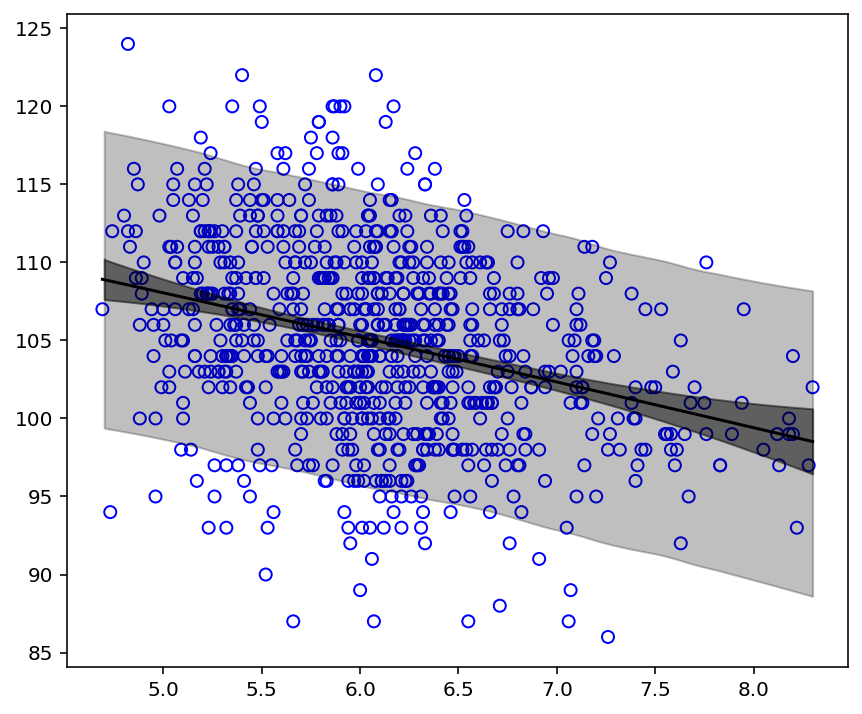

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

ax.scatter(d2['temp'], d2['doy'], facecolors='none', edgecolors='blue')
ax.plot(temp_grid, mu.mean(axis=1), color='black')
az.plot_hdi(temp_grid, mu.T, hdi_prob=.89, ax=ax, color='black', fill_kwargs=dict(alpha=.5))
az.plot_hdi(temp_grid, sim.T, hdi_prob=.89, ax=ax, color='black', fill_kwargs=dict(alpha=.25))
plt.show()

### 4H6.
Simulate the prior predictive distribution for the cherry blossom spline in the chapter. Adjust the prior on the weights and observe what happens. What do you think the prior on the weights is doing?

In [57]:
d2 = d[d['doy'].notna()].reset_index(drop=True)
num_knots = 15
knot_list = np.quantile(d2['year'], q=np.linspace(0, 1, num_knots))

In [58]:
B = bs(d2['year'], knots=knot_list[1:-1], degree=3, include_intercept=True).values

In [59]:
with pm.Model() as model:
    a = pm.Normal('a', mu=100, sigma=5)
    sigma = pm.Exponential('sigma', lam=1/100)
    w = pm.Normal('w', mu=0, sigma=5, shape=B.shape[1])
    mu = pm.Deterministic('mu', a + pm.math.dot(B, w.T))
    D = pm.Normal('D', mu=mu, sigma=sigma, observed=d2['doy'])
    pp = pm.sample_prior_predictive(5000)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


Text(0, 0.5, 'days in year')

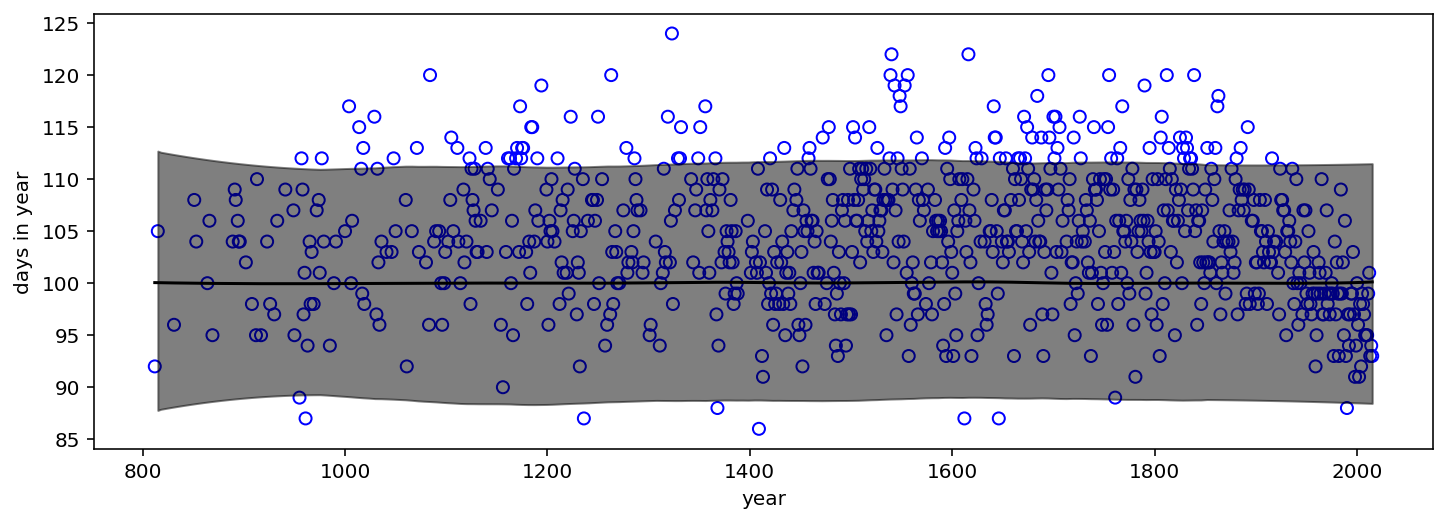

In [60]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(d2.year, d2.doy, edgecolors='blue', facecolors='none')
ax.plot(d2.year, pp['mu'].mean(axis=0), color='black')
az.plot_hdi(d2.year, pp["mu"], color="black", ax=ax, fill_kwargs={'alpha': .5})
ax.set_xlabel("year")
ax.set_ylabel("days in year")

### 4H8.
The cherry blossom spline in the chapter used an intercept α, but technically it doesn’t require one. The first basis functions could substitute for the intercept. Try refitting the cherry blossom spline without the intercept. What else about the model do you need to change to make this work?

In [61]:
d2 = d[d['doy'].notna()].reset_index(drop=True)
num_knots = 15
knot_list = np.quantile(d2['year'], q=np.linspace(0, 1, num_knots))

In [62]:
B = bs(d2['year'], knots=knot_list[1:-1], degree=3, include_intercept=False).values

In [63]:
with pm.Model() as model:
    a = pm.Normal('a', mu=100, sigma=10)
    sigma = pm.Exponential('sigma', lam=1)
    w = pm.Normal('w', mu=0, sigma=10, shape=B.shape[1])
    mu = pm.Deterministic('mu', a + pm.math.dot(B, w.T))
    D = pm.Normal('D', mu=mu, sigma=sigma, observed=d2['doy'])
    trace = pm.sample(10_000, tune=5_000)

<ipython-input-63-8d447e40c58e>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10_000, tune=5_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, sigma, a]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 90 seconds.
The number of effective samples is smaller than 25% for some parameters.


/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


Text(0, 0.5, 'days in year')

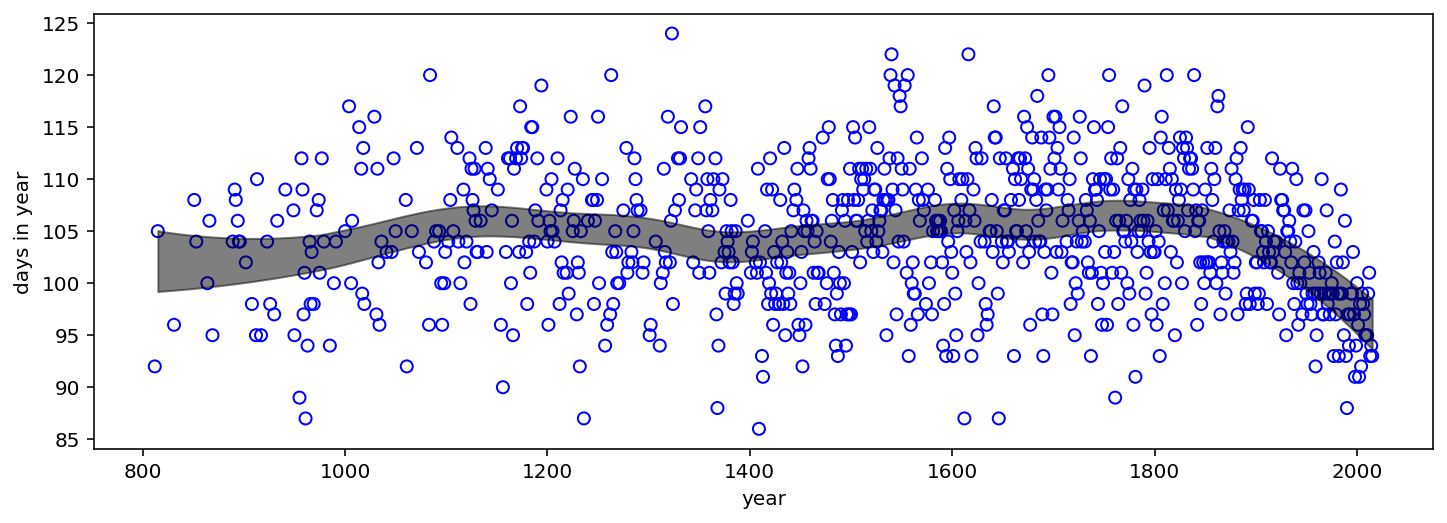

In [64]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(d2.year, d2.doy, edgecolors='blue', facecolors='none')
# ax.plot(d2.year, trace['mu']., color='black')
az.plot_hdi(d2.year, trace["mu"], color="black", ax=ax, fill_kwargs={'alpha': .5})
ax.set_xlabel("year")
ax.set_ylabel("days in year")